In [70]:
import os
import sys
from scgt import GeoTiff
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/')
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/ecoscape-connectivity/')
from EcoLinker.EcoLinker.restorationOptimizer import restorationOptimizer
from ecoscape_connectivity_local import repopulation, util
import matplotlib.pyplot as plt
# import ecoscape_connectivity
from scgt import Tile, GeoTiff
import numpy as np
import torch
import rasterio

DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol/hab_smol.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol/restored_ter_smol.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")
transmission_d = util.read_transmission_csv(PERMEABILITY_PATH)

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol/grad.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_after_restoration.tif")
DEATH_PATH = os.path.join(DATA_PATH, "smol/death.tif")

optimizer = restorationOptimizer(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50)

In [ ]:
# set mpl params
def setup_mpl():
    plt.rcParams['font.family'] = "Helvetica Neue"
    plt.rcParams['font.size'] = 11
    plt.rcParams['figure.figsize'] = (3,3)
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['lines.linewidth'] = 1
setup_mpl()

Restoration based on highest death rates:
1. Compute connectivity with pre-determined seeds
2. Compute death layer by taking (flow/p) * (1-p)
3. Find top n pixels with highest death rates
4. Convert pixels to more permiable terrain

In [ ]:
# Pre-set seeds for determinism...
hab = GeoTiff.from_file(optimizer.habitat_fn)
hab_tile = hab.get_all_as_tile().m.astype(np.float)
seeds = (torch.rand(400,*(hab_tile.shape)) < 0.002) * hab_tile # 1% of pixels are seeds.

In [ ]:
# compute connectivity - not needed unless output is needed
repopulation.compute_connectivity(HABITAT_PATH, TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, transmission_d, single_tile=True)
pre_restoration_conn = optimizer.sum_of_tif(CONNECTIVITY_PATH)

In [3]:
death_tif = optimizer.get_death_layer(optimizer.death_fn)
highest_death = optimizer.get_highest_death_pixels(death_tif)

print(f'Pre-restoration sum of connectivity {pre_restoration_conn}')

pre_restoration_conn = optimizer.sum_of_tif(CONNECTIVITY_PATH)
optimizer.restore_pixels()

# compute connectivity w/ restored terrain
repopulation.compute_connectivity(HABITAT_PATH, RESTORED_TERRAIN_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, transmission_d, single_tile=True, seeds=seeds)
post_restoration_conn = optimizer.sum_of_tif(RESTORED_CONNECTIVITY_PATH)
print(f'Post-restoration sum of connectivity {post_restoration_conn}')

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Pre-restoration sum of connectivity 3393799


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Post-restoration sum of connectivity 3395963


Compare new (post-restoration) connectivity to old connectivity
    - Use same seeds to enforce determinism

In [4]:
# change in connectivity:
delta_conn = int(post_restoration_conn) - int(pre_restoration_conn)
percent_change = delta_conn / pre_restoration_conn

print(f'pre-restoration sum of connectivity {pre_restoration_conn}')
print(f'post-restoration sum of connectivity {post_restoration_conn}')
print(f'change in connectivity: {delta_conn}, or {percent_change.round(7)}%')

pre-restoration sum of connectivity 3393799
post-restoration sum of connectivity 3395963
change in connectivity: 2164, or 0.0006376%


Try to compute regional connectivity gain for each restored pixel...

In [34]:
PRE_TER = os.path.join(DATA_PATH, "smol/pre_ter.tif")
PRE_HAB = os.path.join(DATA_PATH, "smol/pre_hab.tif")
PRE_CONN = os.path.join(DATA_PATH, "smol/pre_conn.tif")
PRE_FLOW = os.path.join(DATA_PATH, "smol/pre_flow.tif")
POST_TER = os.path.join(DATA_PATH, "smol/post_ter.tif")
POST_HAB = os.path.join(DATA_PATH, "smol/post_hab.tif")
POST_CONN = os.path.join(DATA_PATH, "smol/post_conn.tif")
POST_FLOW = os.path.join(DATA_PATH, "smol/post_flow.tif")

In [71]:
death_tif = optimizer.get_death_layer(optimizer.death_fn)
highest_death = optimizer.get_highest_death_pixels(death_tif, n=50)
print(highest_death)

ter = GeoTiff.from_file(optimizer.terrain_fn)
restored_ter = GeoTiff.from_file(optimizer.restored_terr_fn)
hab = GeoTiff.from_file(optimizer.habitat_fn)

window_sz = 16

total_delta_connectivity = 0
total_percent_change = 0.0

permeabilities = []
deaths = []
change_percents = []

for i, (x, y) in enumerate(highest_death.keys()):
    deaths.append(highest_death[(x, y)])
    lat_max, lon_max = rasterio.transform.xy(ter.dataset.transform, y-window_sz, x-window_sz)
    lat_min, lon_min = rasterio.transform.xy(ter.dataset.transform, y+window_sz, x+window_sz)

    pre_ter = ter.crop_to_new_file(PRE_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # pre_ter.draw_geotiff()
    pre_ter.dataset.close()

    pre_hab = hab.crop_to_new_file(PRE_HAB, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # hab_tile = hab.get_all_as_tile().m.astype(np.float)
    # pre_hab.draw_geotiff()
    pre_hab.dataset.close()

    # seed = torch.randint(1, 1000, (1,))[0]
    # seed = i
    repopulation.compute_connectivity(PRE_HAB, PRE_TER, PRE_CONN, PRE_FLOW, transmission_d, single_tile=True, num_simulations=5000)

    # conn_before = GeoTiff.from_file(PRE_CONN)
    # conn_before_tile = conn_before.get_all_as_tile()
    # conn_before.draw_geotiff()

    pre_conn_sum = optimizer.sum_of_tif(PRE_CONN)

    with GeoTiff.from_file(optimizer.terrain_fn) as terrain_geotiff:
        old_terrain = terrain_geotiff.get_pixel_value(x, y)
        permeabilities.append(optimizer.permeability_dict[old_terrain])

    optimizer.change_terrain(x, y, verbose=True)
    post_ter = restored_ter.crop_to_new_file(POST_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # post_ter.draw_geotiff()
    post_ter.dataset.close()

    repopulation.compute_connectivity(PRE_HAB, POST_TER, POST_CONN, POST_FLOW, transmission_d, single_tile=True, num_simulations=5000)
    # conn_after = GeoTiff.from_file(POST_CONN)
    # conn_after.draw_geotiff()
    # conn_after_tile = conn_after.get_all_as_tile()
    post_conn_sum = optimizer.sum_of_tif(POST_CONN)
    
    # change in connectivity:
    delta_conn = int(post_conn_sum) - int(pre_conn_sum)
    percent_change = delta_conn / pre_conn_sum

    change_percents.append(percent_change)

    total_delta_connectivity += delta_conn
    total_percent_change += percent_change

    # diff_tile = Tile(conn_after_tile.w, conn_after_tile.h, conn_after_tile.b, conn_after_tile.c, conn_after_tile.x, conn_after_tile.y, conn_after_tile.m-conn_before_tile.m)
    # diff_tile.draw_tile()

    print(f'pre-restoration sum of connectivity {pre_conn_sum}')
    print(f'post-restoration sum of connectivity {post_conn_sum}')
    print(f'change in connectivity: {delta_conn}, or {percent_change.round(7)}%')

print(f"total_delta_connectivity: {total_delta_connectivity}")
print(f"Average percent change: {total_percent_change / len(highest_death.keys())}")



{(243, 202): 36, (293, 199): 36, (207, 206): 36, (33, 132): 36, (236, 203): 36, (33, 133): 36, (262, 201): 35, (237, 203): 35, (246, 201): 35, (83, 143): 35, (72, 143): 35, (91, 151): 34, (82, 143): 34, (207, 205): 34, (63, 129): 34, (89, 146): 34, (245, 201): 34, (252, 199): 34, (242, 202): 33, (142, 188): 33, (224, 202): 33, (290, 202): 33, (184, 202): 33, (244, 201): 33, (262, 202): 33, (261, 202): 32, (89, 150): 32, (88, 146): 32, (193, 203): 32, (138, 162): 32, (78, 144): 32, (131, 167): 32, (130, 167): 32, (89, 147): 32, (189, 203): 32, (64, 129): 32, (134, 168): 32, (292, 199): 31, (238, 203): 31, (191, 204): 31, (187, 201): 31, (143, 191): 31, (224, 201): 31, (241, 202): 31, (232, 21): 31, (261, 201): 31, (268, 201): 31, (228, 196): 31, (143, 190): 31, (82, 142): 30}
Restoring pixel (243, 202) from permiability 0.2715912408759124 to 1.0
pre-restoration sum of connectivity 4014
post-restoration sum of connectivity 4389
change in connectivity: 375, or 0.093423%
Restoring pixel (2

[36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30]
[0.09342301943198804, -0.005649717514124294, -0.012067578439259855, -0.01183159188690842, 0.07707631014403923, -0.012588212855235552, 0.15965346534653466, 0.14894398530762168, 0.3368747233289066, 0.05357369556937921, 0.04586713792272472, 0.023066970062017578, 0.03773584905660377, 0.02447980416156671, -0.011897919301069088, -0.028686396677050884, 0.1903114186851211, 0.09640221402214022, 0.11303129378794956, 0.024243908411901556, 0.04638635343408649, 0.12890700834789362, 0.02277385561375541, 0.19407321324811155, 0.13395012067578438, 0.08050478677110531, 0.004156617232000821, -0.006474648893120685, 0.007250580046403712, -0.001545993300695697, 0.021213026590976996, 0.006197171651495448, 0.0035687642397725667, 0.04862825469281289, -0.010820797044074954, 0.014726527805632753, -0.000250935781351

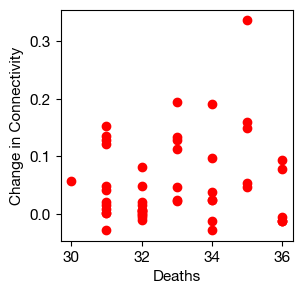

In [75]:
print(deaths)
print(change_percents)
plt.scatter(deaths, change_percents, color="red")
plt.xlabel("Deaths")
plt.ylabel("Change in Connectivity")
plt.show()

In [74]:
print(np.corrcoef(deaths, change_percents))

[[1.         0.12648271]
 [0.12648271 1.        ]]


In [72]:
death_sum = 0
for i in highest_death.values():
    death_sum += i

print(death_sum)


1646


6737/1646 = 4.093

About 4x more connectivity units per potential unit

TODO:
- Look at correlation between amount of permiability restored, and % change in connectivity
- visualize difference before -> after

In [73]:
14649/1646

8.899756986634264